# Instructions for users

### The zip file must have a single folder data which should have folders. Each folder represents a class name in the folders only images pertaining to that class must be contained


In [1]:
import zipfile

zip_file = "data.zip"
extract_to = ""

with zipfile.ZipFile(zip_file, "r") as zip_ref:
    zip_ref.extractall(extract_to)


In [2]:
import tensorflow as tf
from tensorflow import keras
from keras import layers, models, callbacks
from keras.api.preprocessing import image, image_dataset_from_directory
import keras_tuner as kt


2024-08-10 19:51:29.125911: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-10 19:51:29.150233: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-10 19:51:29.150262: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-10 19:51:29.151239: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-10 19:51:29.155849: I tensorflow/core/platform/cpu_feature_gua

In [3]:
data_dir = "data"
batch_size = 1
img_height = 100
img_width = 100

train_ds = image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
)

val_ds = image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
)


AUTOTUNE = tf.data.experimental.AUTOTUNE

class_names = train_ds.class_names
print(f"class_names = {class_names}")

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

num_classes = len(class_names)


Found 14034 files belonging to 6 classes.
Using 11228 files for training.


2024-08-10 19:51:30.648568: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-10 19:51:30.680324: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-10 19:51:30.687009: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Found 14034 files belonging to 6 classes.
Using 2806 files for validation.
class_names = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


In [4]:
def model_builder(hp):
    model = keras.Sequential()
    conv_activation=hp.Choice('conv_activation', values = ['tanh', 'relu', 'selu', 'leaky_relu'])
    dense_activation=hp.Choice('dense_activation', values = ['tanh', 'relu', 'selu', 'leaky_relu'])
    regularizer_choice = hp.Choice('regularizer', values=['l1', 'l2', 'l1_l2'])
    # regularizer_choice = hp.Choice('regularizer', values=['none', 'l1', 'l2', 'l1_l2'])

    def get_regularizer():
        if regularizer_choice == 'l1':
            return keras.regularizers.l1(hp.Float('l1', 1e-6, 1e-2, sampling='log'))
        # elif regularizer_choice == 'none':
        #     return None
        elif regularizer_choice == 'l2':
            return keras.regularizers.l2(hp.Float('l2', 1e-6, 1e-2, sampling='log'))
        else:
            return keras.regularizers.l1_l2(
                l1=hp.Float('l1', 1e-6, 1e-2, sampling='log'),
                l2=hp.Float('l2', 1e-6, 1e-2, sampling='log')
            )


    model.add(layers.Rescaling(1.0 / 255, input_shape=[img_height, img_width, 3]))
    for i in range(hp.Int('num_conv_layers', min_value=1, max_value=4, step=1)):

        model.add(layers.Conv2D(
            hp.Int(f'conv_{i}_units', min_value=16, max_value=64, step=16),
            kernel_size=(3, 3),
            activation=conv_activation,
            kernel_regularizer=get_regularizer()
        ))
        model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Flatten())

    for i in range(hp.Int('num_dense_layers', min_value=1, max_value=3, step=1)):
        model.add(layers.Dense(
            hp.Int(f'dense_{i}_units', min_value=16, max_value=256, step=16),
            activation=dense_activation,
            kernel_regularizer=get_regularizer()
        ))
        model.add(layers.Dropout(hp.Float(f'dropout_{i}', 0.0, 0.5, step=0.1)))

    model.add(layers.Dense(num_classes))

    model.compile(
            optimizer=keras.optimizers.Adam(
                hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')
            ),
            loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            metrics=['accuracy']
        )

    return model


In [5]:
tuner = kt.Hyperband(
    model_builder,
    objective='val_accuracy',
    max_epochs=30,
    factor = 4,
    directory='tuned_models',
    project_name='model_final'
)

early_stopping = callbacks.EarlyStopping(
    monitor="val_accuracy",
    patience=5,
    restore_best_weights=True,
)


/home/arnav-fedora/miniconda3/envs/tensorflow/lib/python3.12/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [6]:

tuner.search(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=[early_stopping]
)


Trial 44 Complete [00h 05m 35s]
val_accuracy: 0.7947255969047546

Best val_accuracy So Far: 0.8071988821029663
Total elapsed time: 01h 24m 13s


In [7]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
model_final = tuner.hypermodel.build(best_hps)


In [8]:
history = model_final.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=[early_stopping],
)


Epoch 1/30
11228/11228 ━━━━━━━━━━━━━━━━━━━━ 15s 1ms/step - accuracy: 0.4497 - loss: 2.1509 - val_accuracy: 0.6254 - val_loss: 1.3706
Epoch 2/30
11228/11228 ━━━━━━━━━━━━━━━━━━━━ 13s 1ms/step - accuracy: 0.5893 - loss: 1.3993 - val_accuracy: 0.6661 - val_loss: 1.1577
Epoch 3/30
11228/11228 ━━━━━━━━━━━━━━━━━━━━ 14s 1ms/step - accuracy: 0.6411 - loss: 1.2107 - val_accuracy: 0.6889 - val_loss: 1.0955
Epoch 4/30
11228/11228 ━━━━━━━━━━━━━━━━━━━━ 14s 1ms/step - accuracy: 0.6641 - loss: 1.1239 - val_accuracy: 0.6974 - val_loss: 1.0287
Epoch 5/30
11228/11228 ━━━━━━━━━━━━━━━━━━━━ 13s 1ms/step - accuracy: 0.6787 - loss: 1.0697 - val_accuracy: 0.7160 - val_loss: 0.9852
Epoch 6/30
11228/11228 ━━━━━━━━━━━━━━━━━━━━ 13s 1ms/step - accuracy: 0.6901 - loss: 1.0206 - val_accuracy: 0.7263 - val_loss: 0.9403
Epoch 7/30
11228/11228 ━━━━━━━━━━━━━━━━━━━━ 14s 1ms/step - accuracy: 0.7098 - loss: 0.9760 - val_accuracy: 0.7352 - val_loss: 0.9197
Epoch 8/30
11228/11228 ━━━━━━━━━━━━━━━━━━━━ 14s 1ms/step - accuracy: 

In [9]:
model_final.save("model_final.keras")


In [10]:
model = tf.keras.models.load_model("model_final.keras")


In [11]:
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)         │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 98, 98, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 49, 49, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 47, 47, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 23, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 21, 21, 48)     │        27,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 10, 10, 48)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 8, 8, 32)       │        13,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 4, 4, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 80)             │        41,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 80)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 6)              │           486 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 307,412 (1.17 MB)

 Trainable params: 102,470 (400.27 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 204,942 (800.56 KB)

In [12]:
val_loss, val_acc = model.evaluate(val_ds, verbose=2)
train_loss, train_acc = model.evaluate(train_ds, verbose=2)
print(f"Validation accuracy: {val_acc}")
print(f"Validation loss: {val_loss}")
print(f"Train accuracy: {train_acc}")
print(f"Train loss: {train_loss}")


2806/2806 - 2s - 737us/step - accuracy: 0.7933 - loss: 0.7722
11228/11228 - 7s - 610us/step - accuracy: 0.8082 - loss: 0.7185
Validation accuracy: 0.7933000922203064
Validation loss: 0.7722266316413879
Train accuracy: 0.8082472681999207
Train loss: 0.7185012698173523


In [13]:
def predict_image(image_path):
    img = image.load_img(image_path, target_size=(img_height, img_width))
    img_array = image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])

    print(
        "This image most likely belongs to {} with a {:.2f} percent confidence.".format(
            class_names[tf.argmax(score)], 100 * tf.reduce_max(score)
        )
    )


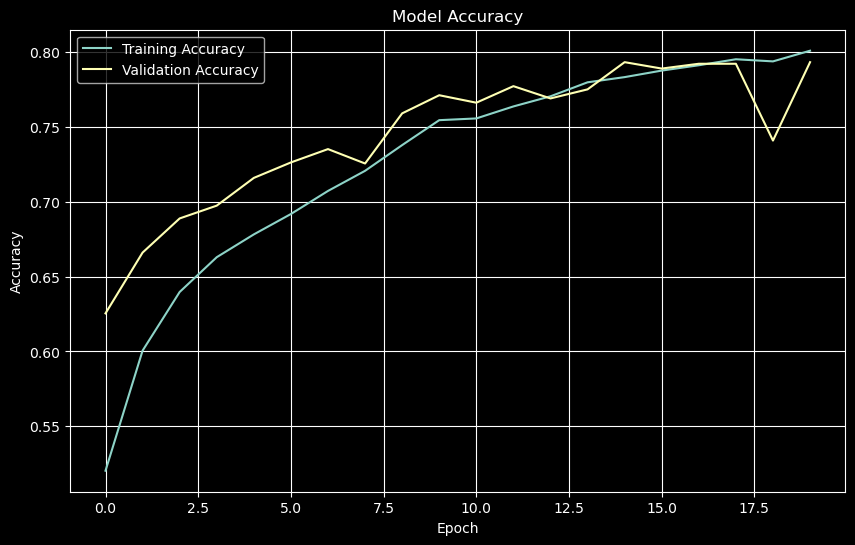

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')

plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


In [20]:
predict_image("test_data/buildings/24205.jpg")
predict_image("test_data/forest/20306.jpg")
predict_image("test_data/glacier/20187.jpg")
predict_image("test_data/mountain/20154.jpg")
predict_image("test_data/sea/20255.jpg")
predict_image("test_data/street/20070.jpg")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
This image most likely belongs to buildings with a 88.01 percent confidence.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
This image most likely belongs to forest with a 92.51 percent confidence.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
This image most likely belongs to glacier with a 69.34 percent confidence.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
This image most likely belongs to mountain with a 76.29 percent confidence.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
This image most likely belongs to sea with a 51.11 percent confidence.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
This image most likely belongs to street with a 97.22 percent confidence.
